In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygal 
from pygal import Config
from pywaffle import Waffle
import flask
# import sqviz as vz

%matplotlib inline

In [7]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
df = pd.read_csv(url, error_bad_lines=False)

In [9]:
df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [10]:
# df['date'] = pd.to_datetime(df.date)

In [11]:
df_maine = df[df.state == 'Maine']
df_maine.head()

,date,county,state,fips,cases,deaths
1466,2020-03-12,Androscoggin,Maine,23001.0,1,0
1742,2020-03-13,Androscoggin,Maine,23001.0,1,0
1743,2020-03-13,Cumberland,Maine,23005.0,1,0
2082,2020-03-14,Androscoggin,Maine,23001.0,1,0
2083,2020-03-14,Cumberland,Maine,23005.0,2,0


In [12]:
df_maine.county.unique()

array(['Androscoggin', 'Cumberland', 'Lincoln', 'Unknown', 'Kennebec',
       'Oxford', 'York', 'Penobscot', 'Sagadahoc', 'Knox', 'Waldo',
       'Franklin', 'Somerset', 'Hancock'], dtype=object)

In [13]:
df_state_tot = df_maine.groupby('date').sum()

In [14]:
df_state_tot.head()

,fips,cases,deaths
date,,,
2020-03-12,23001.0,1,0
2020-03-13,46006.0,2,0
2020-03-14,46006.0,3,0
2020-03-15,69021.0,12,0
2020-03-16,69021.0,17,0


df_state_tot = df_state_tot.head().reset_index()

In [15]:
dates = df_state_tot.index.values.tolist()
cases = df_state_tot.cases.values.tolist()
deaths = df_state_tot.deaths.values.tolist()

In [16]:
dates_major = dates[0::3]

## Plot Total Cases and Deaths

In [23]:
bar_chart = pygal.Bar(x_label_rotation=20, show_minor_x_labels=False, show_legend=False, y_title = 'Number of Cases')
bar_chart.title = 'Total COVID-19 Cases in Maine'
bar_chart.x_labels = dates
bar_chart.x_labels_major = dates_major
bar_chart.add('Number of Cases', cases)

bar_chart.render_to_file('plots/total_cases_maine.svg')                          # Save the svg to a file
# bar_chart.render_response()

<Response 23685 bytes [200 OK]>

In [19]:
help(bar_chart.render_response)

Help on method render_response in module pygal.graph.public:

render_response(**kwargs) method of pygal.graph.bar.Bar instance
    Render the graph, and return a Flask response



In [13]:
bar_chart = pygal.Bar(x_label_rotation=20, show_minor_x_labels=False, show_legend=False, y_title='Number of Deaths')
bar_chart.title = 'Total COVID-19 Deaths in Maine'
bar_chart.x_labels = dates
bar_chart.x_labels_major = dates_major

bar_chart.add('Deaths', deaths)

bar_chart.render_to_file('plots/total_deaths_maine.svg')                          # Save the svg to a file

## Plot New Daily Cases

In [14]:
df_state_tot['new_cases'] = df_state_tot.cases.diff()
df_state_tot['new_cases'][0] = 1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
df_state_tot.head()

,fips,cases,deaths,new_cases
date,,,,
2020-03-12,23001.0,1,0,1.0
2020-03-13,46006.0,2,0,1.0
2020-03-14,46006.0,3,0,1.0
2020-03-15,69021.0,12,0,9.0
2020-03-16,69021.0,17,0,5.0


In [16]:
bar_chart = pygal.Bar(x_label_rotation=20, 
                      show_minor_x_labels=False,
                      show_legend=False,
                      y_title = 'Number of New Cases',
                      x_title = 'Day')
bar_chart.title = 'Daily New COVID-19 Cases in Maine'
bar_chart.x_labels = dates
bar_chart.x_labels_major = dates_major
bar_chart.add('Number of New Cases', df_state_tot.new_cases.to_list())

bar_chart.render_to_file('plots/new_cases_maine.svg')                          # Save the svg to a file

## Plot Daily Deaths

In [17]:
df_state_tot['new_deaths'] = df_state_tot.deaths.diff()
df_state_tot['new_deaths'][0] = 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
df_state_tot.tail()

,fips,cases,deaths,new_cases,new_deaths
date,,,,,
2020-03-28,253169.0,213,1,43.0,0.0
2020-03-29,276194.0,253,3,40.0,2.0
2020-03-30,276194.0,275,4,22.0,1.0
2020-03-31,276194.0,303,5,28.0,1.0
2020-04-01,299203.0,344,7,41.0,2.0


In [19]:
bar_chart = pygal.Bar(x_label_rotation=20, 
                      show_minor_x_labels=False,
                      show_legend=False,
                      y_title = 'Number of Deaths',
                      x_title = 'Day')
bar_chart.title = 'Daily COVID-19 Deaths in Maine'
bar_chart.x_labels = dates
bar_chart.x_labels_major = dates_major
bar_chart.add('Number of New Deaths', df_state_tot.new_deaths.to_list())

bar_chart.render_to_file('plots/new_deaths_maine.svg')                          # Save the svg to a file

## Plot County-Level Data

In [20]:
df_maine_today = df_maine[df_maine.date == df_maine.date.max()]

In [21]:
df_maine_today

,date,county,state,fips,cases,deaths
24835,2020-04-01,Androscoggin,Maine,23001.0,12,0
24836,2020-04-01,Cumberland,Maine,23005.0,192,5
24837,2020-04-01,Franklin,Maine,23007.0,2,0
24838,2020-04-01,Hancock,Maine,23009.0,1,0
24839,2020-04-01,Kennebec,Maine,23011.0,17,1
24840,2020-04-01,Knox,Maine,23013.0,5,0
24841,2020-04-01,Lincoln,Maine,23015.0,8,0
24842,2020-04-01,Oxford,Maine,23017.0,9,0
24843,2020-04-01,Penobscot,Maine,23019.0,13,0
24844,2020-04-01,Sagadahoc,Maine,23023.0,10,0


In [22]:
df_maine_today.sort_values(by=['cases'], ascending=False, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
bar_chart = pygal.Bar(x_label_rotation=20, show_legend=False, y_title='Number of Cases', x_title='County')
bar_chart.title = 'COVID-19 Cases by County (March 31, 2020)'
bar_chart.x_labels = df_maine_today.county.to_list()
bar_chart.add('Cases', df_maine_today.cases.to_list())

bar_chart.render_to_file('plots/current_cases_by_county.svg')                          # Save the svg to a file

##  County Case Growth

#### Cumberland

In [24]:
bar_chart = pygal.Bar(x_label_rotation=20, show_legend=False, y_title='Number of Cases', show_minor_x_labels=False)
bar_chart.title = 'COVID-19 Cases in Cumberland County'
bar_chart.x_labels = df_maine[df_maine.county=='Cumberland'].date.to_list()
bar_chart.x_labels_major = df_maine[df_maine.county=='Cumberland'].date.to_list()[0::3]
bar_chart.add('Cases', df_maine[df_maine.county=='Cumberland'].cases.to_list())

bar_chart.render_to_file('plots/cumberland_cases.svg')                          # Save the svg to a file

#### York

In [25]:
bar_chart = pygal.Bar(x_label_rotation=20, show_legend=False, y_title='Number of Cases', show_minor_x_labels=False)
bar_chart.title = 'COVID-19 Cases in York County'
bar_chart.x_labels = df_maine[df_maine.county=='York'].date.to_list()
bar_chart.x_labels_major = df_maine[df_maine.county=='York'].date.to_list()[0::3]
bar_chart.add('Cases', df_maine[df_maine.county=='York'].cases.to_list())

bar_chart.render_to_file('plots/york_cases.svg')                          # Save the svg to a file

#### Kennebec

In [26]:
bar_chart = pygal.Bar(x_label_rotation=20, show_legend=False, y_title='Number of Cases', show_minor_x_labels=False)
bar_chart.title = 'COVID-19 Cases in Kennebec County'
bar_chart.x_labels = df_maine[df_maine.county=='Kennebec'].date.to_list()
bar_chart.x_labels_major = df_maine[df_maine.county=='Kennebec'].date.to_list()[0::3]
bar_chart.add('Cases', df_maine[df_maine.county=='Kennebec'].cases.to_list())

bar_chart.render_to_file('plots/kennebec_cases.svg')                          # Save the svg to a file

## Cases Per Capita

#### County Population

https://data.census.gov/cedsci/profile?g=0500000US23005&q=Cumberland
https://data.census.gov/cedsci/profile?g=0500000US23031&q=York
https://data.census.gov/cedsci/profile?g=0500000US23017&q=Oxford
https://data.census.gov/cedsci/profile?g=0500000US23023&q=Sagadahoc
https://data.census.gov/cedsci/profile?g=0500000US23001&q=Androscoggin
    https://data.census.gov/cedsci/profile?g=0500000US23015&q=Lincoln
        https://data.census.gov/cedsci/profile?g=0500000US23011&q=Kennebec
https://data.census.gov/cedsci/profile?g=0500000US23007&q=Franklin
    https://data.census.gov/cedsci/profile?g=0500000US23027&q=Waldo
        https://data.census.gov/cedsci/profile?g=0500000US23025&q=Somerset
            https://data.census.gov/cedsci/profile?g=0500000US23009&q=Hancock
https://data.census.gov/cedsci/profile?g=0500000US23029&q=Washington
https://data.census.gov/cedsci/profile?g=0500000US23021&q=Piscataquis
    https://data.census.gov/cedsci/profile?g=0500000US23019&q=Penobscot
        https://data.census.gov/cedsci/profile?g=0500000US23003&q=Aroostook

In [27]:
population_data = {'Cumberland': 290944,
                   'York':203102,
                   'Oxford':57325,
                   'Sagadahoc':35277,
                   'Androscoggin':107444,
                   'Lincoln':34067,
                   'Kennebec':121545,
                   'Franklin':30019,
                   'Knox':39823,
                   'Waldo':39418,
                   'Somerset':50710,
                   'Hancock':54541,
                   'Washington':31694,
                   'Piscataquis':16877,
                   'Penobscot':151748,
                   'Aroostook': 68269,
                   'Unknown':np.nan}

In [28]:
df_population = pd.DataFrame.from_dict(population_data, orient='index',columns=['population'])

In [29]:
df_maine_today = df_maine_today.merge(df_population, left_on='county', right_index=True)

In [30]:
df_maine_today['cases_per_hundred_thousand'] = df_maine_today.cases/(df_maine_today.population/100000)

In [31]:
df_maine_today.head()

,date,county,state,fips,cases,deaths,population,cases_per_hundred_thousand
24836,2020-04-01,Cumberland,Maine,23005.0,192,5,290944.0,65.992081
24848,2020-04-01,York,Maine,23031.0,65,1,203102.0,32.003624
24839,2020-04-01,Kennebec,Maine,23011.0,17,1,121545.0,13.986589
24843,2020-04-01,Penobscot,Maine,23019.0,13,0,151748.0,8.566834
24835,2020-04-01,Androscoggin,Maine,23001.0,12,0,107444.0,11.168609


In [32]:
df_maine_today = df_maine_today.round({'cases_per_hundred_thousand':0})

In [33]:
bar_chart = pygal.Bar(x_label_rotation=20,
                      show_legend=False,
                      y_title='Cases per 100,000 Residents',
                      x_title='County')
bar_chart.title = 'COVID-19 Cases per 100,000 Residents (March 31, 2020)'
bar_chart.x_labels = df_maine_today.county.to_list()
bar_chart.add('Cases', df_maine_today.cases_per_hundred_thousand.to_list())

bar_chart.render_to_file('plots/current_cases_per_hundred_thous.svg')                          # Save the svg to a file

## Make a df with Press Herald Data (https://www.pressherald.com/2020/03/17/track-maines-coronavirus-cases-by-county/)


*press herald data used for recovered counts for March 26-31

In [39]:
df_state_tot['recovered']=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,24,36,41,41,68,80]

In [40]:
df_state_tot.tail()

,fips,cases,deaths,new_cases,new_deaths,recovered,active_cases
date,,,,,,,
2020-03-28,253169.0,213,1,43.0,0.0,36,176
2020-03-29,276194.0,253,3,40.0,2.0,41,209
2020-03-30,276194.0,275,4,22.0,1.0,41,230
2020-03-31,276194.0,303,5,28.0,1.0,68,230
2020-04-01,299203.0,344,7,41.0,2.0,80,257


In [41]:
df_state_tot['active_cases'] = df_state_tot.cases - df_state_tot.deaths - df_state_tot.recovered

In [42]:
bar_chart = pygal.StackedBar(x_label_rotation=20, show_minor_x_labels=False)
bar_chart.title = 'Maine COVID-19 Cases by Status'
bar_chart.x_labels = df_state_tot.index.values.tolist()
bar_chart.x_labels_major = df_state_tot.index.values.tolist()[0::3]

bar_chart.add('Active Cases', df_state_tot.active_cases.values.tolist())
bar_chart.add('Deaths', df_state_tot.deaths.values.tolist())
bar_chart.add('Recovered Cases', df_state_tot.recovered.values.tolist())


bar_chart.render_to_file('plots/case_status.svg')                          # Save the svg to a file

## Hospitalized Patients 

In [43]:
df_state_tot['hospitalized']=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,57,63]

In [44]:
df_state_tot.head()

,fips,cases,deaths,new_cases,new_deaths,recovered,active_cases,hospitalized
date,,,,,,,,
2020-03-12,23001.0,1,0,1.0,0.0,0,1,0
2020-03-13,46006.0,2,0,1.0,0.0,0,2,0
2020-03-14,46006.0,3,0,1.0,0.0,0,3,0
2020-03-15,69021.0,12,0,9.0,0.0,0,12,0
2020-03-16,69021.0,17,0,5.0,0.0,0,17,0


In [45]:
df_hosp = df_state_tot[df_state_tot.hospitalized > 0]
df_hosp

,fips,cases,deaths,new_cases,new_deaths,recovered,active_cases,hospitalized
date,,,,,,,,
2020-03-30,276194.0,275,4,22.0,1.0,41,230,49
2020-03-31,276194.0,303,5,28.0,1.0,68,230,57
2020-04-01,299203.0,344,7,41.0,2.0,80,257,63


In [50]:
bar_chart = pygal.Bar(x_label_rotation=20,
                      show_minor_x_labels=False,
                      show_legend=False,
                      y_title = 'Number of Hospitalized Patients')
bar_chart.title = 'Number of Patients Hospitalized for COVID-19 in Maine'
bar_chart.x_labels = df_hosp.index.values.tolist()
bar_chart.add('Count Hospitalized', df_hosp.hospitalized.values.tolist())

bar_chart.render_to_file('plots/hospitalized.svg')                          # Save the svg to a file

## Patient Age

In [149]:
df_age = pd.DataFrame.from_dict({'age_range':['< 20','20s', '30s', '40s', '50s', '60s', '70s','80+'], 
                                 'cases': [6,35,28,54,69,77,46,29]})
df_age.head()

,age_range,cases
0,< 20,6
1,20s,35
2,30s,28
3,40s,54
4,50s,69


In [150]:
total_count = df_age.cases.sum()
df_age['percent_of_tot'] = df_age.cases/total_count*100
df_age = df_age.round({'percent_of_tot':1})
df_age.head()

,age_range,cases,percent_of_tot
0,< 20,6,1.7
1,20s,35,10.2
2,30s,28,8.1
3,40s,54,15.7
4,50s,69,20.1


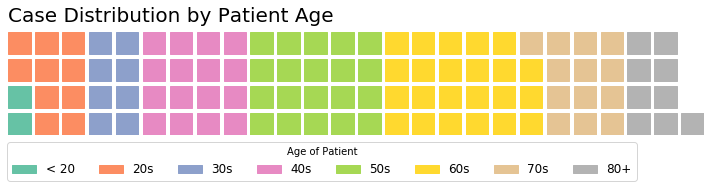

In [154]:
fig = plt.figure(
    FigureClass=Waffle, 
    rows=4,
    values=df_age.percent_of_tot,
    labels=list(df_age.age_range),
    legend={'loc': 'lower left',
            'bbox_to_anchor': (-.01, -0.5),
            'ncol': len(df_age.percent_of_tot),
            'fontsize': 12,
            'title':'Age of Patient'
           },
    title={'label': 'Case Distribution by Patient Age',
           'loc': 'left',
           'pad':10,
           'fontdict': {'fontsize': 20}},
    figsize=(10, 8)  # figsize is a parameter of plt.figure

)

In [153]:
bar_chart = pygal.Bar(x_label_rotation=20,
                      show_legend=False,
                      y_title='Percent of Cases (%)',
                      x_title='Age Group')
bar_chart.title = 'Case Distribution by Patient Age'
bar_chart.x_labels = df_age.age_range
bar_chart.add('% of Cases', df_age.percent_of_tot.to_list())

bar_chart.render_to_file('plots/age_range.svg')                          # Save the svg to a file